In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
"tf_flowers",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
as_supervised=True,
with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

In [ ]:
print(class_names)
print(n_classes)
print(dataset_size)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5
3670


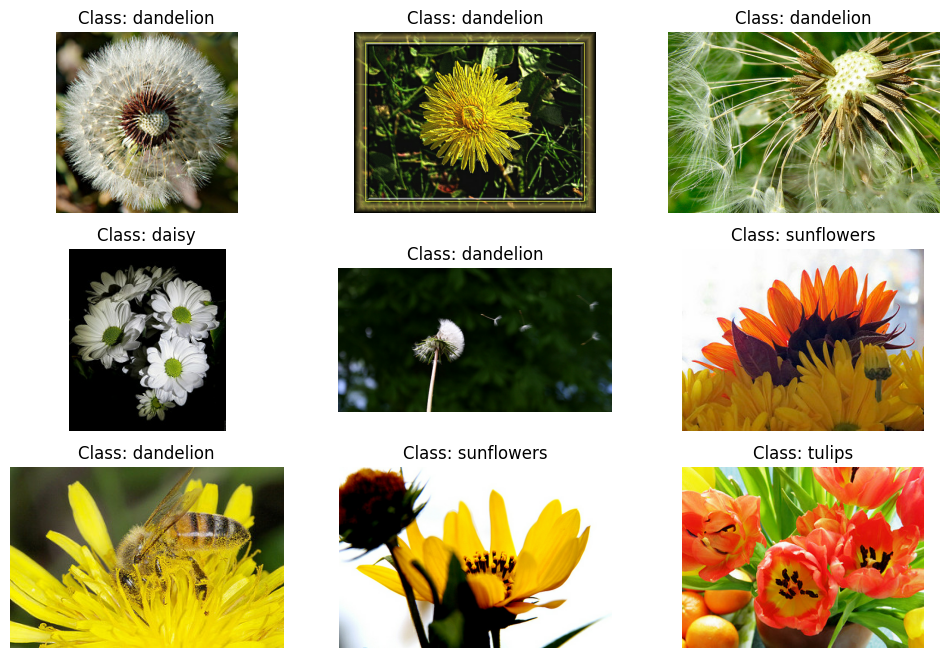

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
  index += 1
  plt.subplot(3, 3, index)
  plt.imshow(image)
  plt.title("Class: {}".format(class_names[label]))
  plt.axis("off")
plt.show(block=False)

In [ ]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  return resized_image, label

In [ ]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


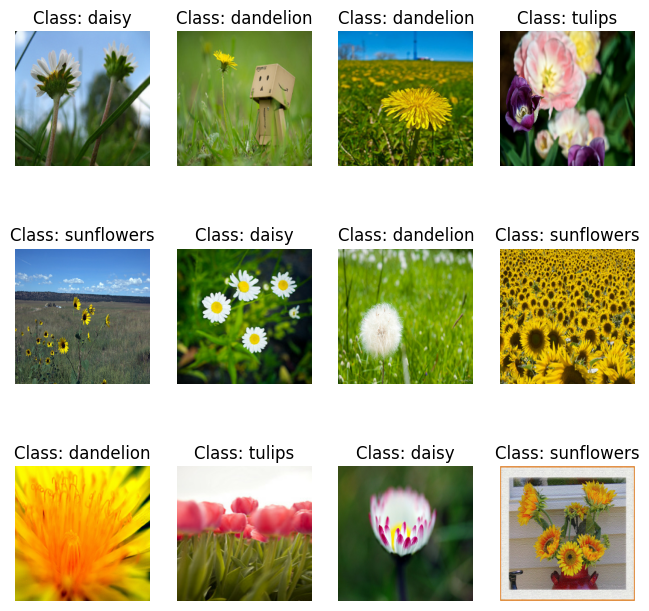

In [ ]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
print(sample_batch)
for X_batch, y_batch in sample_batch:
  for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(X_batch[index]/255.0)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, offset=-1))

model.add(layers.Conv2D(32, (7, 7), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

In [ ]:
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/86 [==============================] - 445s 5s/step - loss: 1.6632 - accuracy: 0.2856 - val_loss: 1.3871 - val_accuracy: 0.4356
Epoch 2/10
86/86 [==============================] - 471s 5s/step - loss: 1.3414 - accuracy: 0.4658 - val_loss: 1.2444 - val_accuracy: 0.4592
Epoch 3/10
86/86 [==============================] - 424s 5s/step - loss: 1.2085 - accuracy: 0.5291 - val_loss: 1.2178 - val_accuracy: 0.5245
Epoch 4/10
86/86 [==============================] - 405s 5s/step - loss: 1.1171 - accuracy: 0.5658 - val_loss: 1.1002 - val_accuracy: 0.5590
Epoch 5/10
86/86 [==============================] - 421s 5s/step - loss: 0.9552 - accuracy: 0.6392 - val_loss: 1.1485 - val_accuracy: 0.5554
Epoch 6/10
86/86 [==============================] - 428s 5s/step - loss: 0.7909 - accuracy: 0.7118 - val_loss: 1.3077 - val_accuracy: 0.5844
Epoch 7/10
86/86 [==============================] - 419s 5s/step - loss: 0.6219 - accuracy: 0.7627 - val_loss: 1.1532 - val_accuracy: 0.6025
Epoch 8/10
86/86 [======

In [ ]:
train_acc = model.evaluate(train_set)[1]
val_acc = model.evaluate(valid_set)[1]
test_acc = model.evaluate(test_set)[1]

 1/86 [..............................] - ETA: 4:15 - loss: 0.0885 - accuracy: 0.9688

KeyboardInterrupt: ignored

In [ ]:
import pickle

with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump((train_acc, val_acc, test_acc), f)

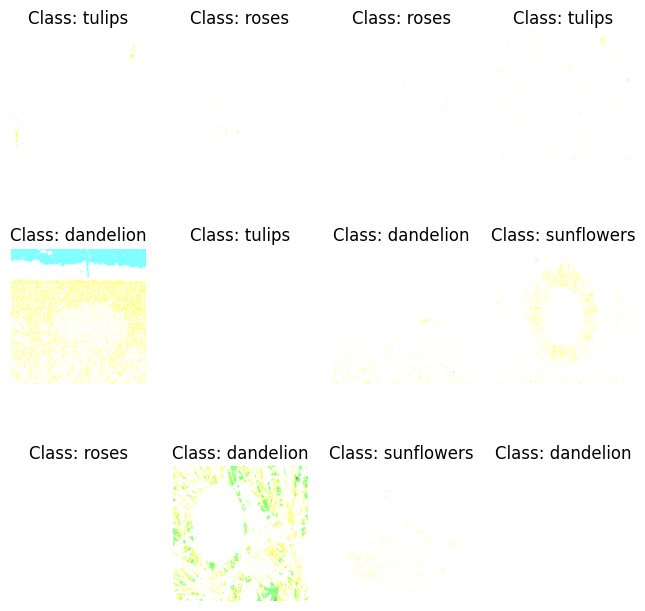

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
  for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()


In [ ]:
base_model = tf.keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False
)

tf.keras.utils.plot_model(base_model)

avg_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output_layer = tf.keras.layers.Dense(n_classes, activation="softmax")(avg_pooling_layer)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_set, epochs=5)

Epoch 1/5
86/86 [==============================] - 626s 7s/step - loss: 5.5264 - accuracy: 0.3274
Epoch 2/5
86/86 [==============================] - 617s 7s/step - loss: 2.7744 - accuracy: 0.4215
Epoch 3/5
86/86 [==============================] - 610s 7s/step - loss: 2.3139 - accuracy: 0.4767
Epoch 4/5
86/86 [==============================] - 601s 7s/step - loss: 1.8052 - accuracy: 0.5200
Epoch 5/5
86/86 [==============================] - 576s 7s/step - loss: 1.5664 - accuracy: 0.5589


In [ ]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_set, epochs=10)

In [ ]:
def evaluate_model(model, dataset):
    loss, accuracy = model.evaluate(dataset)
    return accuracy

acc_train = evaluate_model(model, train_set)
acc_valid = evaluate_model(model, valid_set)
acc_test = evaluate_model(model, test_set)

evaluation_results = (acc_train, acc_valid, acc_test)

import pickle

with open('xception_acc.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)